# RQ4: How frequently do developers use the conversion functions?


In [22]:
import os
import zipfile
from pathlib import Path

import pandas as pd
import json
from nb_utils import unzip, DATA_DIR

# Extracted results, load to frame and delete the large CSV
unzip(DATA_DIR / 'sfconvertbot_pr_metadata.csv.zip', DATA_DIR)
df1 = pd.read_csv(Path('../../data/sfconvertbot_pr_metadata.csv'))
os.remove(DATA_DIR / 'sfconvertbot_pr_metadata.csv')
df2 = pd.read_csv(Path('../../data/hf_conversions.csv'))
# fix timestamps to make it consistent across datasets
for index, row in df2.iterrows():
    pr_url = row['pr_url'].split("#")[0]
    header = row['header_metadata'] if row['header_metadata'] else ""
    json_header = json.loads(row['header_metadata']) if header.startswith('{') else None
    df2.loc[index,'time'] = json_header['discussion']['createdAt'] if json_header else None
# drop duplicates from df2
df2.drop_duplicates(subset='pr_url', inplace=True)

# exclude from df2 pr_url that are in df
df3 = df1.copy()
df3['pr_url'] = df1['pr_url'].str.split('#').str[0].str.strip()
df2 = df2[~df2['pr_url'].isin(df3['pr_url'])]
# merge the two dataframes together based on the pr_url
df4 = pd.concat([df1, df2], ignore_index=True)
# drop duplicates
df4 = df4.drop_duplicates(subset='pr_url')
len(df1), len(df2), len(df4), len(df4.drop_duplicates(subset='pr_url'))

(45394, 933, 46327, 46327)

In [23]:
# drop duplicates
df4 = df4.drop_duplicates(subset='pr_url')
df4.to_csv(DATA_DIR / 'NEW_sfconvertbot_pr_metadata.csv', index=False)
# zip it
# !zip -j $DATA_DIR/NEW_sfconvertbot_pr_metadata.csv.zip $DATA_DIR/NEW_sfconvertbot_pr_metadata.csv



## Data Preparation

In [20]:
from pathlib import Path
from nb_utils import unzip, DATA_DIR, RESULTS_DIR
import pandas as pd
import os

# Extracted results, load to frame and delete the large CSV
unzip(DATA_DIR / 'sfconvertbot_pr_metadata.csv.zip', DATA_DIR)
df1 = pd.read_csv(Path('../../data/sfconvertbot_pr_metadata.csv'))
os.remove(DATA_DIR / 'sfconvertbot_pr_metadata.csv')

# series for collecting dataset stats, columns = metric / value
stats = pd.Series()
stats.loc['Number of PRs collected from SFConvertBot Community Activity'] = len(df1)

# remove rows with missing values
df1 = df1.dropna()
stats.loc['Number of PRs after removing missing values'] = len(df1)

# remove rows with invalid JSONs
df1 = df1[df1['discussion_metadata'].str.startswith('{')]
stats.loc['Number of PRs after removing invalid JSONs'] = len(df1)

# add a date column
df1['date'] = df1['time'].str.split('T').str[0]
df1['date'] = df1['date'].str.split(' ').str[0]
# ensure date column is a datetime object
df1['date'] = pd.to_datetime(df1['date'])
# filter in place, keep only commits before Oct 31 2024 (including)
df1 = df1[df1['date'] <= pd.Timestamp(2024, 10, 31)]
stats.loc['Number of PRs after filtering by date'] = len(df1)

# exclude PRs made on spaces/safetensors/convert
df1 = df1[~df1['pr_url'].str.contains('/spaces/safetensors/convert/discussions')]
stats.loc['Number of PRs after filtering by URL'] = len(df1)

# show some stats
stats.loc['Number of repositories'] = df1['model_id'].nunique()
stats.loc['Average number of PRs per repository'] = df1['model_id'].value_counts().mean()
stats.loc['First commit time'] = df1['time'].min()
stats.loc['Last commit time'] = df1['time'].max()
# save stats to csv
stats.to_csv(RESULTS_DIR / 'rq4_dataset_stats.csv', header=False)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/sfconvertbot_pr_metadata.csv'

## Extracting PR Statuses


In [54]:
from tqdm import tqdm
import json


def label_status(row: pd.Series) -> str:
    # check if the PR has conflicts
    if row['conflicts']:
        return f"{row['status']} (has conflicts)"
    return row['status']


# Extract status changes from discussion metadata
for index, row in tqdm(df1.iterrows(), total=len(df1)):
    # add a column to track status changes
    status_changes = []
    discussion = json.loads(row['discussion_metadata'])['discussion']
    created_at = pd.to_datetime(discussion['createdAt'])
    author = discussion['author']['name']
    if author.lower() != 'sfconvertbot':
        # remove from df
        df1.drop(index, inplace=True)
        continue
    first_status_change_date = None
    for event in discussion['events']:
        event_type = event['type']
        if event_type == 'status-change':
            status_changes.append(event['data']['status'])
            # this means author has been deleted
            if 'author' not in event:
                event['author'] = {'name': 'UNKNOWN (likely a deleted account)'}
            # convert to datetime
            if not first_status_change_date and event['author']['name'].lower() != 'sfconvertbot':
                first_status_change_date = pd.to_datetime(event['createdAt'])

    df1.at[index, 'status_changes'] = ";".join(status_changes)

    # add a column to track files with conflicts
    df1.at[index, 'conflicts'] = ""
    header = json.loads(row['header_metadata'])
    df1.at[index, 'status'] = header['discussion']['status']
    # check if there are conflicting files
    conflicting_files = header['discussion'].get('filesWithConflicts', [])
    df1.at[index, 'conflicts'] = ";".join(conflicting_files)
    # time to first response
    df1.at[
        index, 'time_to_first_response'] = first_status_change_date - created_at if first_status_change_date else "No response"
    # adjust the status
    df1.at[index, 'status'] = label_status(df1.loc[index])

# show only those in 2022
df_2022 = df1[df1['date'].dt.year == 2022]
df_2022

100%|██████████| 45504/45504 [00:53<00:00, 851.18it/s] 


,pr_url,discussion_metadata,header_metadata,model_id,time,date,status_changes,conflicts,status,time_to_first_response,year


## Stacked bar chart per year for the distribution of different status.


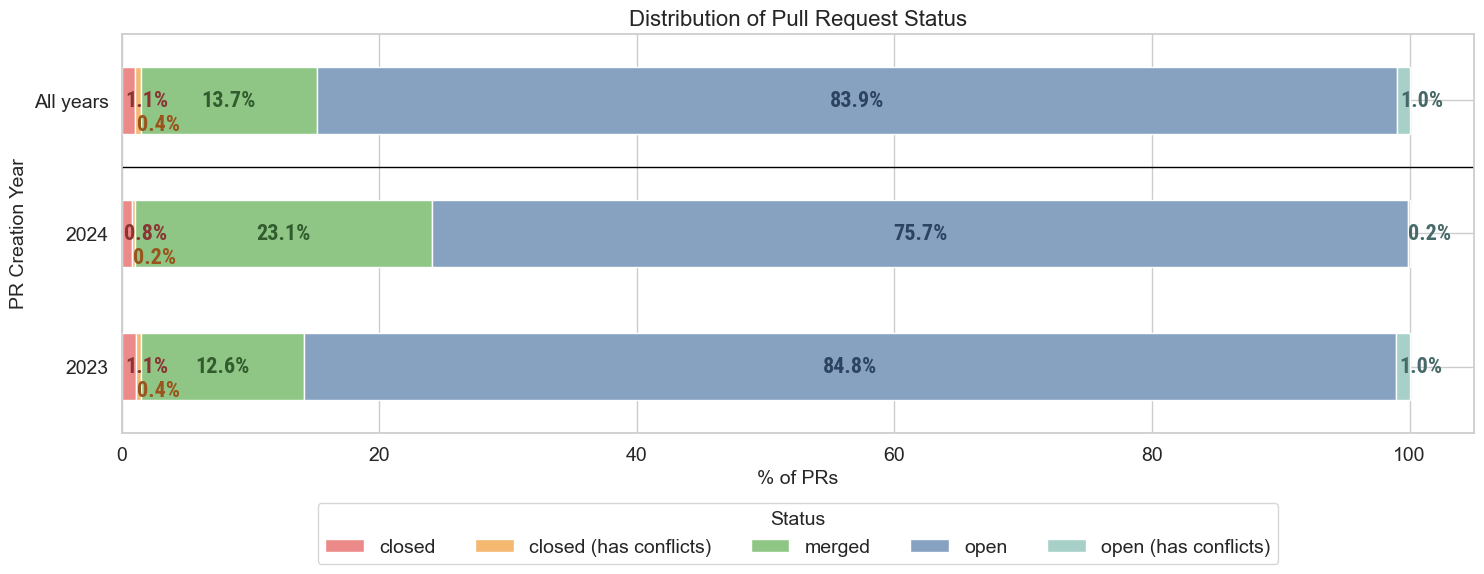

In [55]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from nb_utils import RESULTS_DIR

# Add a year column
df1['year'] = df1['date'].dt.year

# Group by year and status, and calculate counts
status_counts = df1.groupby(['year', 'status']).size().unstack(fill_value=0)

# Calculate percentage distribution for each year
status_percentage = status_counts.div(status_counts.sum(axis=1), axis=0) * 100

# Calculate total counts for all years and add as a new row
total_counts = df1['status'].value_counts(normalize=True) * 100  # Percentage distribution for the entire dataset
status_percentage.loc['All years'] = total_counts.reindex(status_percentage.columns).fillna(0)  # Add 'Total' row

# Define Tableau-like color palette for the status categories
colors = {
    'open': '#87a1c1',  # Lighter Blue
    'merged': '#8fc685',  # Lighter Green
    'closed': '#ec8a89',  # Lighter Red
    'closed (has conflicts)': '#f5b870',  # Lighter Orange
    'open (has conflicts)': '#a7d0c8',  # Lighter Teal
}

# Define even darker versions of the Tableau-like color palette
darker_colors = {
    'open': '#2d4460',  # Even Darker Blue
    'merged': '#325c2d',  # Even Darker Green
    'closed': '#8a3434',  # Even Darker Red
    'closed (has conflicts)': '#9a531b',  # Even Darker Orange
    'open (has conflicts)': '#466a68',  # Even Darker Teal
}

# Load the Roboto Condensed font from your local assets folder
roboto_condensed = FontProperties(fname='../../assets/RobotoCondensed-Bold.ttf')

# Plot the 100% stacked bar chart as horizontal with Tableau-like colors
fig, ax = plt.subplots(figsize=(15, 6))
status_percentage.plot(kind='barh', stacked=True, ax=ax, color=[colors[status] for status in status_percentage.columns])

# Add data labels for each segment with matching colors
for i, (year, row) in enumerate(status_percentage.iterrows()):
    cumulative = 0
    delta = 0.18  # Offset for small segments
    was_small = False
    for status, value in row.items():
        if value > 5:  # Only display labels for segments > 5% to prevent overlap
            ax.text(cumulative + value / 2, i, f"{value:.1f}%", ha='center', va='center',
                    fontsize=16, fontweight='bold', fontproperties=roboto_condensed,
                    color=darker_colors[status])  # Set text color to match bar color
            was_small = False
        elif value > 0:
            # For small segments, place the label outside with matching color
            ax.text(cumulative + value / 4, i + (delta if was_small else 0), f"{value:.1f}%", ha='left', va='center',
                    fontsize=16, fontweight='bold', fontproperties=roboto_condensed,
                    color=darker_colors[status])
            delta = -delta
            was_small = True
        cumulative += value

# Add a red line separating the "Total" bar from the yearly data
ax.axhline(y=len(status_percentage) - 1.5, color='black', linewidth=1)

# Customize plot with larger font sizes
plt.title('Distribution of Pull Request Status', fontsize=16)
plt.ylabel('PR Creation Year', fontsize=14)
plt.xlabel('% of PRs', fontsize=14)
# increase tick size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Move the legend outside and below the chart with increased label size
plt.legend(title='Status', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=len(status_percentage.columns),
           fontsize=14, title_fontsize=14)
plt.tight_layout()

# Save the plot to a PDF
plt.savefig(RESULTS_DIR / 'RQ4StatusDistribution.pdf', format='pdf', bbox_inches='tight')

plt.show()


## Time to response
We plot a box plot of the time to first response for each status category.

/var/folders/cw/6strsjk52m3f3jfpzgyc4ktc0000gq/T/ipykernel_55320/2706830643.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_to_response['time_to_first_response'] = pd.to_timedelta(df_time_to_response['time_to_first_response'])
/var/folders/cw/6strsjk52m3f3jfpzgyc4ktc0000gq/T/ipykernel_55320/2706830643.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_to_response['time_to_first_response'] = df_time_to_response['time_to_first_response'].dt.total_seconds() / 60 #3600


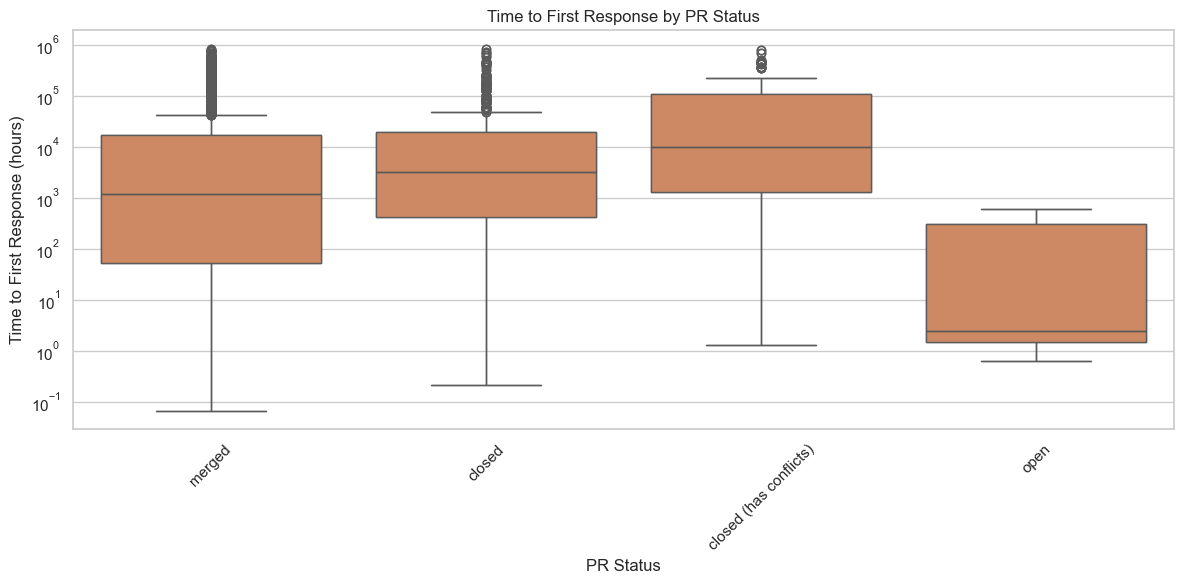

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from nb_utils import RESULTS_DIR

# Filter out PRs with no response
df_time_to_response = df1[df1['time_to_first_response'] != 'No response']
# Convert time to response to minutes
df_time_to_response['time_to_first_response'] = pd.to_timedelta(df_time_to_response['time_to_first_response'])
df_time_to_response['time_to_first_response'] = df_time_to_response[
                                                    'time_to_first_response'].dt.total_seconds() / 60  #3600
# Plot the box plot
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
# do a box plot including the outliers in the plot (dont leave it out as circles)
sns.boxplot(data=df_time_to_response, x='status', y='time_to_first_response', showfliers=True)
sns.boxplot(data=df_time_to_response, x='status', y='time_to_first_response', showfliers=True)
# sns.boxplot(data=df_time_to_response, x='status', y='time_to_first_response', palette=colors)
# do a violin plot
# sns.violinplot(data=df_time_to_response, x='status', y='time_to_first_response', palette=colors)
plt.yscale('log')  # Log scale for better visualization
plt.title('Time to First Response by PR Status')
plt.xlabel('PR Status')
plt.ylabel('Time to First Response (hours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'RQ4TimeToFirstResponse.pdf', format='pdf')
plt.show()



## Identify Relevant Discussions

Criteria:
1. PR has at least two non-empty comment.
2. PR has at least two different authors (not counting the SFConvertBot) engaging in the discussion.
3. The average comment size is more than 4 words.

In [34]:
from nb_utils import RESULTS_DIR
from tqdm import tqdm
import json

min_num_authors = 2
min_num_comments = 2
min_avg_comment_size = 0

output_file = RESULTS_DIR / 'sfconvertbot_pr_metadata_filtered.csv'
# create a dataframe to store the filtered PRs
df_filtered = pd.DataFrame(columns=df1.columns)
# create lambda function that checks whether string.lower() == 'sfconvertbot'
is_sfconvertbot = lambda x: x.lower() == 'sfconvertbot'

# iterate over dataframe
for index, row in tqdm(df1.iterrows(), total=len(df1)):
    # parse as JSON (it should be a string)
    discussion = json.loads(row['discussion_metadata'])['discussion']
    # extract events and original author
    events = discussion['events']
    original_author = discussion['author']
    # criteria:
    num_words, num_non_empty_comments = 0, 0
    authors = set()
    if not is_sfconvertbot(original_author["name"]):
        authors.add(original_author["name"])

    for event in events:
        # print("\t",event)
        event_type = event['type']
        if event_type == 'comment' and not event['data']['hidden']:
            event_author = event['author']
            num_non_empty_comments += 1
            if not is_sfconvertbot(event_author["name"]):
                authors.add(event_author["name"])
            num_words += len(event['data']['latest']['raw'].split())

    should_include = (num_non_empty_comments >= min_num_comments and
                      len(authors) >= min_num_authors and
                      num_words / num_non_empty_comments >= min_avg_comment_size)
    # add the row to the filtered dataframe
    if should_include:
        df_filtered.loc[len(df_filtered)] = row
        title = f"{discussion['title']} by {original_author['name']} ({row['model_id']})"
        df_filtered.loc[len(df_filtered) - 1, 'title'] = title
        df_filtered.loc[len(df_filtered) - 1, 'num_comments'] = num_non_empty_comments
        df_filtered.loc[len(df_filtered) - 1, 'num_authors'] = len(authors)
        df_filtered.loc[len(df_filtered) - 1, 'avg_comment_size'] = num_words / num_non_empty_comments
        df_filtered.loc[len(df_filtered) - 1, 'authors'] = ";".join(authors)

# add a source column
df_filtered['source'] = 'SFConvertBot PRs'
# rename PR URL column to url
df_filtered.rename(columns={'pr_url': 'url'}, inplace=True)
# rename discussion_metadata to json_content
df_filtered.rename(columns={'discussion_metadata': 'json_content'}, inplace=True)
# reorder columns
df_filtered = df_filtered[['source', 'title', 'url', 'num_comments', 'num_authors', 'avg_comment_size', 'authors']]
# save the filtered dataframe
df_filtered.to_csv(output_file, index=True)
print("Number of PRs after filtering: ", len(df_filtered))
print("Saved to: ", output_file)

100%|██████████| 45504/45504 [00:04<00:00, 9540.04it/s] 

Number of PRs after filtering:  27
Saved to:  ../../results/sfconvertbot_pr_metadata_filtered.csv
